In [1]:
#libraries
import thesisFunctions
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
from scipy.stats import normaltest
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 12.0)

%matplotlib inline

/home/pipe/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Introduccion

El proposito de este trabajo es actualizar el indice CAPECO creado por el INDEC, con datos del censo de 2001, con los datos del censo 2010. El modelo subyacente utiliza las siguientes variables para aproximarse al ingreso individual de las personas:

* Años de escolaridad primaria (*primary*)
* Años de escolaridad secundaria (*secondary*)
* Años de escolaridad universitaria (*university*)
* Varón entre 14 y 24 años (*male_14to24*)
* Varón entre 25 y 34 años (*male_25to34*)
* Mujer entre 14 y 24 años (*female_14to24*)
* Mujer entre 25 y 34 años (*female_25to34*)
* Mujer entre de 35 años o más (*female_35more*)

El modelo original incluye la región a la que pertenece la persona (los ingresos varían según la región del país) y si la persona percibía jubilación o pensión. Sin embargo en este trabajo únicamente analizamos el modelo para la región del Aglomerado Gran Buenos Aires y en el censo 2010 no se preguntó en el formulario básico sobre la percepción de jubilación o pensión.

# El modelo
Creamos una tabla de datos con los registros personales de la EPH para el tercer trimestre de 2010, las varibables de interés en la especificación requerida por el modelo y el ponderador. Uno de los requerimientos del modelo es trabajar con el logaritmo del ingreso. Esta variable será nuestra regresor.

In [2]:
ind3t10 = pd.read_csv('../dt/t310/ind3t10.csv') 
ind3t10.head()

,CODUSU,NRO_HOGAR,COMPONENTE,AGLOMERADO,PONDERA,familyRelation,female,age,schoolLevel,finishedYear,...,male_25to34,female_14to24,female_25to34,female_35more,education,education2,age2,id,lnIncome,lnIncomeT
0,302468,1,1,32,1287,1,1,20,7.0,2,...,0,1,0,0,13.0,169.0,400,3024681,0.000000,7.600902
1,302468,1,2,32,1287,10,1,20,6.0,2,...,0,1,0,0,13.0,169.0,400,3024681,0.000000,7.600902
2,307861,1,1,32,1674,1,0,42,2.0,1,...,0,0,0,0,7.0,49.0,1764,3078611,8.006368,8.006368
3,307861,1,2,32,1674,2,1,44,7.0,1,...,0,0,0,1,17.0,289.0,1936,3078611,7.937375,7.937375
4,307861,1,3,32,1674,3,0,13,4.0,2,...,0,0,0,0,7.0,49.0,169,3078611,0.000000,0.000000


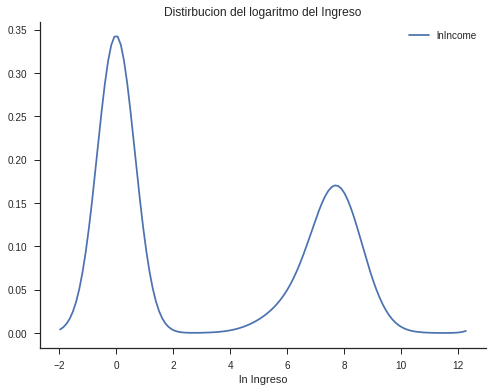

In [3]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.kdeplot(data=ind3t10.lnIncome, ax=ax)    
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso')
plt.xlabel('ln Ingreso')
#plt.xlabel('Educacion')
#plt.ylabel('ln Ingreso')

Numerosos casos registran nulos ingresos 0 y/o actualmente no tienen trabajo. Este modelo basado en el paradigma de capital humano, se sustenta en los retornos que el mercado de trabajo ofrece a la inversión en educación por parte de los individuos. De modo que, solo puede dar cuenta de los ingresos laborales de aquellos que tienen trabajo. Esto implica una limitación a la hora de percibir el conjunto de los ingresos (de los cuales los laborales, si bien una parte importante, constituyen solo una porción). Al mismo tiempo, las personas con trabajo que no perciben ingresos y tienen trabajo constituyen un caso extremo que perjudica la performance del modelo. Puede deberse a que el trabajo es reciente y aún no cobraron el primer salario.

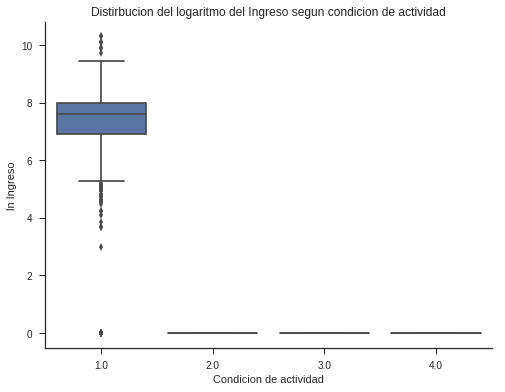

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.boxplot(x="activity", y="lnIncome", data=ind3t10)
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso segun condicion de actividad')
plt.xlabel('Condicion de actividad')
plt.ylabel('ln Ingreso')

Por ello, eliminamos del set de datos que utilizaremos para el modelo a aquellos que no perciben ningun tipo de ingreso o que no se encuentran trabajando.

In [5]:
jobsAndIncome = ((ind3t10.activity==1) & (ind3t10.lnIncome>1))
ind3t10Model = ind3t10.copy().loc[jobsAndIncome,:]

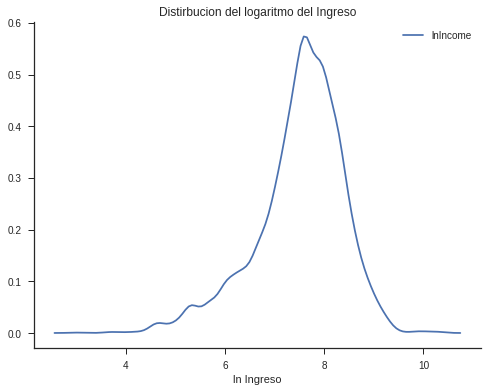

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.kdeplot(ind3t10Model.lnIncome)
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso')
plt.xlabel('ln Ingreso')

La distirbución de la variable se asemeja a una distribución normal, con p-value menor a 5%. Esto mejora la performance del modelo.

In [7]:
normaltest(ind3t10Model.lnIncome)

NormaltestResult(statistic=430.11709871839003, pvalue=3.9926268882108378e-94)

Siendo las dos variable fundamentales de este modelo la edad, los años de escolaridad y el género, podemos explorar como se comportan estas variables en relación al logaritmo del ingreso. Dado que la EPH utiliza ponderadores, los resultados visuales pueden ser algo engañosos en la medida en que cada punto no representa igual cantidad de casos. 

In [8]:
dataMasc = ind3t10Model.loc[ind3t10Model.female==0,:]
dataFem = ind3t10Model.loc[ind3t10Model.female==1,:]

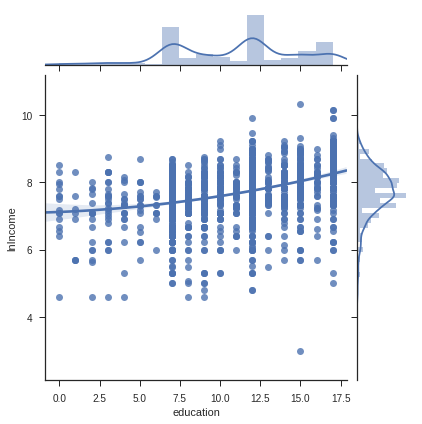

In [9]:
g = sns.JointGrid(x="education", y="lnIncome", data=dataMasc)  
g.plot_joint(sns.regplot,order=2)
g.plot_marginals(sns.distplot)
g.savefig('../img/capitulo3/ingresoVeduM.png')

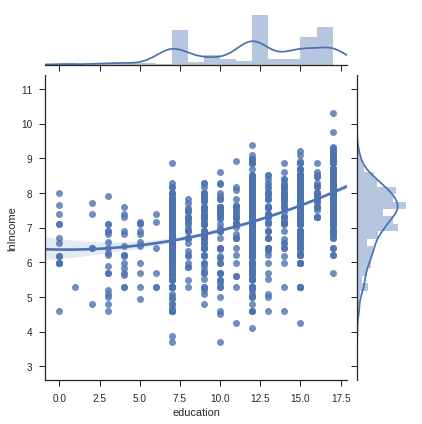

In [10]:
g = sns.JointGrid(x="education", y="lnIncome", data = dataFem)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)
g.savefig('../img/capitulo3/ingresoVeduF.png')

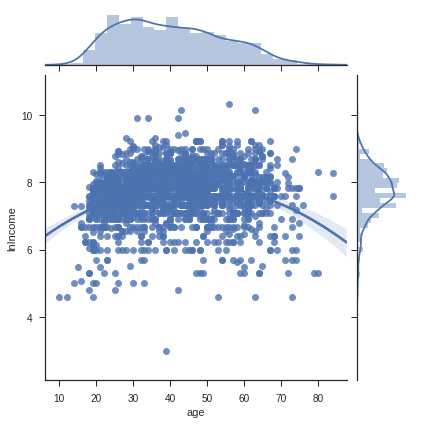

In [11]:
g2 = sns.JointGrid(x="age", y="lnIncome", data=dataMasc)  
g2.plot_joint(sns.regplot, order=2)  
g2.plot_marginals(sns.distplot)

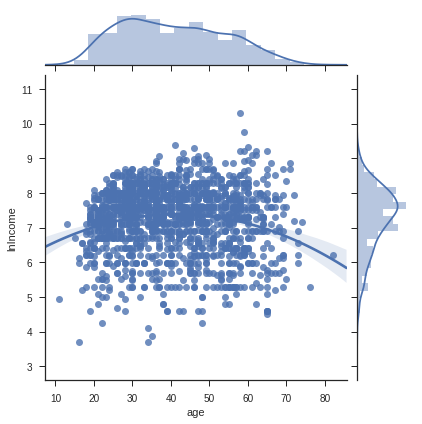

In [12]:
g2 = sns.JointGrid(x="age", y="lnIncome", data=dataFem)  
g2.plot_joint(sns.regplot, order=2)  
g2.plot_marginals(sns.distplot)

El comportamiento de la variable es similar (a pesar de una media de ingreso superior en los hombres). A mayor escolarización mayor salario. Pero esta relación no es lineal, sino que cada año de escolaridad de los tramos superiores ofrece mayores retornos que cada año de los tramos inferiores de escolaridad. Así por ejemplo un año adicional de universidad incrementa más el salario que un año adicional de primaria.

En lo que corresponde a la edad, parece haber una relación creciente hasta pasados los 30 años. Llegada esa edad hay un amesetamiento por el cual no hay incrementos salariales a partir de la edad, para luego comenzar un proceso descendente (el año que inicia el cambio de tendencia hacia el descenso cambia de acuerdo al género: en las mujeres este proceso parece ser durante los 50s mientras que en los hombres en los 60s, lo que coincide con las diferencias en las edades jubilatorias legales).

# El modelo individual

A continuación procedemos a correr el modelo para todos los individuos con ingresos y que se encuentren empleados. La performance del mismo es disimil. Si bien por un lado todos los parametros son estadisticamente significativos para cualquier nivel de confianza, el modelo en su ocnjunto alcanza un R2 de solo 27%. Esto quiere decir que este modelo solo puede dar cuenta del 27% de la variabilidad del logaritmo del ingreso. De todos modos es importante recordar que este modelo no considera elementos fundamentales para el ingreso como la cantidad de horas trabajadas o la rama en la que se desempeña cada persona. Diferentes ramas tienen diferentes productividades y por lo tanto pagan diferentes salarios. 

De todos modos, el objetivo último de este modelo es ofrecer fundamento para los coeficientes del CAPECO. En todo caso veremos al final que capacidad tiene el CAPECO para dar cuenta de la variabilidad del ingreso. 

En primer lugar, el intercepto da cuenta del ingreso esperado para un hombre adulto de 35 años o más con 0 años de escolaridad en cualquiera de los 3 niveles. Este constituye el caso base o registro con el cual compararemos al resto de los casos.

En segundo lugar los coeficientes dan cuenta de una relación Log-Nivel, esto quiere decir, por tomar el ejemplo del primer coeficiente (años de escolaridad primaria), que un año de escolaridad primaria ofrece un incremento de 7.87% en el ingreso. Dicho de otro modo, un hombre adulto de 35 años o más con 1 año de escolaridad, gana un 7.87% más que nuestro caso base (un hombre adulto de 35 años o más con 0 años de escolaridad). Del mismo modo, un año de escolaridad secundaria ofrece un incremento de 8.38% y un año de escolaridad superior ofrece 12.21%. Como es de esperar, los rendimientos no son lineales. Esto quiere decir que en el mercado laboral se valorizan más los años de escolaridad secundaria que los de primaria y los de educación superior a los de secundaria. El supuetso subyacente es que la productividad del trabajo aumenta con la capacitación que ofrece el sistema educativo.

En tercer lugar, los parámetros vinculados a la edad para los hombres, actúan como penalidades. Es decir, se supone que la edad conlleva experiencia y con ella mayor productividad. A su vez, el ciclo vital conlleva que los gastos de personas de tramos etarios superiores sean mayores. Es por ello que los hombres entre 14 y 24 años de edad sin años de escolaridad, ganarán un 42,12% menos que el caso base, manteniendo todas las otras variables consideradas en el modelo constantes. A su vez, un hombre entre 25 y 34 años sin años de escolaridad tendrá un ingreso 15,47% menor al del caso registro.    

Finalmente, es necesario tomar en consideración el efecto del género conjugado con la edad. En primer lugar, parámetro que da cuenta del efecto del género al comparar una mujer de 35 años o más sin años de escolaridad con nuestro caso base (un hombre de idénticas características), nos dice que dicha mujer tendría un ingreso 58.43% menor. Para los otros tramos de edades, una mujer entre 14 y 24 años dicha diferencia es de un 92.96 % menos y entre 25 y 34 años es de 62.64% menos. 

In [13]:
model = thesisFunctions.runModel(ind3t10Model, income = 'lnIncome', variables= [
        'primary','secondary','university',
        'male_14to24','male_25to34',
        'female_14to24', 'female_25to34', 'female_35more'])

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.274
Model:                            WLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     169.6
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          1.71e-243
Time:                        18:16:02   Log-Likelihood:                -4124.3
No. Observations:                3608   AIC:                             8267.
Df Residuals:                    3599   BIC:                             8322.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.8690      0.093     73.616      0.0

## Evaluacion de la regresion

In [14]:
variables= [
        'primary','secondary','university',
        'male_14to24','male_25to34',
        'female_14to24', 'female_25to34', 'female_35more']
    
X = sm.add_constant(ind3t10Model.copy().loc[:,variables].values)
ind3t10Model['predicted'] = model.predict(X)

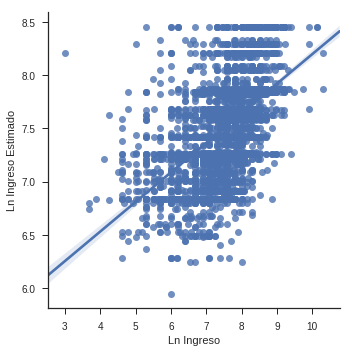

In [15]:
sns.lmplot(x = 'lnIncome', y ='predicted',data=ind3t10Model)
plt.xlabel('Ln Ingreso')
plt.ylabel('Ln Ingreso Estimado')

el ln del ingreso y los residuos tienne una relacion lineal

In [16]:
from statsmodels.graphics.gofplots import qqplot

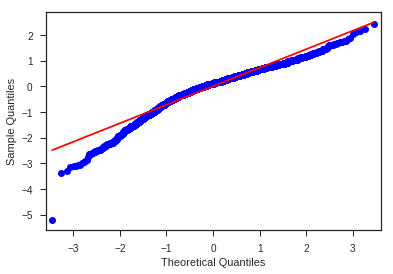

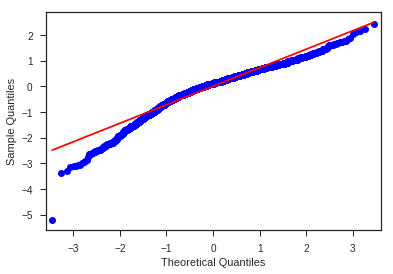

In [17]:
#https://www.coursera.org/learn/regression-modeling-practice/lecture/q2xna/python-lesson-4-evaluating-model-fit-pt-1
qqplot(model.resid,line='r')

Este grafico muestra que los residuos no estan perfectamente distribuidos segun la normal

In [18]:
ind3t10Model['resid'] = ind3t10Model.lnIncome - ind3t10Model.predicted 
print 'media ponderada de los residuos:%.4f'%np.average(ind3t10Model.resid, weights=ind3t10Model.PONDERA)


media ponderada de los residuos:0.0001


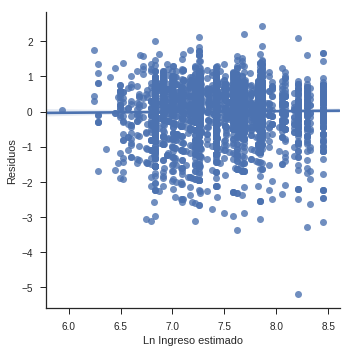

In [19]:
sns.lmplot(x = 'predicted', y ='resid',data=ind3t10Model)
plt.ylabel('Residuos')
plt.xlabel('Ln Ingreso estimado')

In [20]:
ind3t10Model['residStd'] = (ind3t10Model.resid - ind3t10Model.resid.mean()) / ind3t10Model.resid.std()

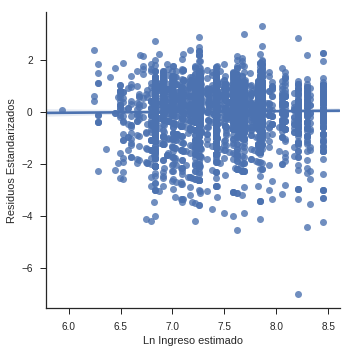

In [21]:
sns.lmplot(x = 'predicted', y ='residStd',data=ind3t10Model)
plt.ylabel('Residuos Estandarizados')
plt.xlabel('Ln Ingreso estimado')

Como se puede observar, los residuos se mueven mayoritariamente dentro de la franja de los 2 desvíos estándar, con algunos casos moviendose entre los 2 y 3 desvíos estándar per debajo de la media, indicando una sobreestimacion en nuestro modelo 

# Creacion de coeficientes de CAPECO

A partir de estos parámetros del modelo, es necesario recontruir los coeficientes del CAPECO en base al modelo con datos actualizados con la EPH del tercer trimestre de 2010.

## Condicion de Percepcion CP - Genero y edad

Consideramos la base de los inactivos como coeficiente 0 y el caso base (hombre de 35 años o más sin educación) como 1. A partir de esto establemos las proporciones contra el caso base en base a género y edad. Esto quiere decir que se evalúa el valor que predice el modelo subyacente al CAPECO para el caso base y luego se compara contra el valor predicho por el modelo para otro caso donde se modifique una variable en una unidad. Es decir, se compara un hombre de 35 años o más sin educación contra un hombre entre 25 y 34 años sin educación para obtener el coeficiente para ese grupo etario. Como se puede observar, se registran las mismas "penalidades" que en el modelo subyacente y que se encontraban en el CAPECO en base a datos de 2001.  

Obviamente el caso registro siempre vale 1, sin importar el año. En lo que refiere a las penalidades por juventud mientras que para el tramo de hombres entre 25 y 34 años no cambió mucho de 2001 a 2010 (0.83 contra 0.86), el tramo de 14 a 24 disminutó dichas penalidades (de 0.46 a 0.65). Mayores estudios sobre el mercado de trabajo son necesarios, aunque es posible arriesgar una hipótesis. El mercado dinámico de las nuevas tecnologías que creció enormemente en esa década, donde se puede presumir mejor adaptación por parte de los jóvenes en general, puede haber actuado como contrapeso a la falta de experiencia. 

La situación de la mujer es paradógica. Comparar a la mujer de 35 años o más sin educación (lo que nos daría el efecto aislado del género más allá del efecto de la edad) muestra que la situación de la mujer empeoró levemente de 2001 a 2010 (pasa de tener un coeficiente de 0.60 a 0.56). Lo mismo sucede con el tramo de edad de 25 a 34 años (de 0.54 a 0.53). Sin embargo, al igual que con los hombres, existe una mejora para el tramo de 14 a 24 con respecto al 2001 (de 0.33 a 0.39).

In [29]:
#varones
varon35 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

varon34 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 1,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

varon24 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 1, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
#mujeres
mujer35 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 1)
mujer34 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 1, female_35tomore = 0)
mujer24 = thesisFunctions.predictModelo(modelo=model, primary = 0, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 1, female_25to34 = 0, female_35tomore = 0)
#CP table data
cp = pd.DataFrame({'categoria':['inactivo','varon35mas','varon34-25','varon24-14','mujer35mas','mujer34-25','mujer24-14'],
                  'cp':[0,varon35/varon35,varon34/varon35,varon24/varon35,mujer35/varon35,mujer34/varon35,mujer24/varon35]})

cp

,categoria,cp
0,inactivo,0.000000
1,varon35mas,1.000000
2,varon34-25,0.856660
3,varon24-14,0.656251
4,mujer35mas,0.557506
5,mujer34-25,0.534522
6,mujer24-14,0.394728


In [30]:
cp.to_csv('../dt/capecoCoefTables/cp.csv',index=False)


In [34]:
#chequeo de datos
ind3t10['CP'] = [thesisFunctions.coeficientePercepcion(ind3t10.iloc[i,:]) for i in range(ind3t10.shape[0])]
ind3t10.loc[:,['activity','age','female','CP']].head(10)

,activity,age,female,CP
0,3.0,20,1,0.000000
1,3.0,20,1,0.000000
2,1.0,42,0,1.000000
3,1.0,44,1,0.557506
4,3.0,13,0,0.000000
5,4.0,8,0,0.000000
6,3.0,68,1,0.000000
7,1.0,38,0,1.000000
8,1.0,28,1,0.534522
9,1.0,63,0,1.000000


## Valorización de los anios de Escolaridad - VAE

En el trabajo del CAPECO de 2001, se decidió utilizar primaria completa como caso base de referencia. Esto quiere decir, que 7 años de escolaridad producían un valor de 7 para el coeficiente del VAE. Se mantuvo el mismo criterio en este trabajo con el fin de mantener la comparabilidad. Se evaluó el modelo para el caso base de un hombre de 25 años o más con 7 años de escolaridad primaria y se normalizó a 7. Luego se comparó este valor con los diferentes valores de años de escolaridad de los diferentes niveles. 

La existencia de diversos sistemas educativos en diferentes provincias, así como las variaciones en los mismos hacia el interior de una provincia entre 2001 y 2010 hace realmente dificultoso el computar una variable como años de escolaridad. De todos modos se optó por una forma que intente compatibilizar los sistemas, aún sabiendo que puede haber dificultades en el cómputo. Por ejemplo una persona con séptimo grado de primaria completo en 2001 no es lo mismo que una persona con 7 de EGB, o 1 de la secundaria de la nueva Ley de Educación que conviertió esos niveles en secundaria. En todo caso, el código fuente de la función que realizó dichos cómputos contiene explícitamente las decisiones tomadas y se encuentra disponible en el repositorio para escrutinio de todo aquel que quiera explorar este problema.

### Primaria


In [35]:
primariaCompleta = thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria6 = thesisFunctions.predictModelo(modelo=model, primary = 6, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria5 = thesisFunctions.predictModelo(modelo=model, primary = 5, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria4 = thesisFunctions.predictModelo(modelo=model, primary = 4, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria3 = thesisFunctions.predictModelo(modelo=model, primary = 3, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria2 = thesisFunctions.predictModelo(modelo=model, primary = 2, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

primaria1 = thesisFunctions.predictModelo(modelo=model, primary = 1, secondary = 0, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)


In [36]:
print 'primaria6:', primaria6 * 7 / primariaCompleta
print 'primaria5:', primaria5 * 7 / primariaCompleta
print 'primaria4:', primaria4 * 7 / primariaCompleta
print 'primaria3:', primaria3 * 7 / primariaCompleta
print 'primaria2:', primaria2 * 7 / primariaCompleta
print 'primaria1:', primaria1 * 7 / primariaCompleta
print 'sin educacion:', varon35 * 7 / primariaCompleta

primaria6: 6.47025341774
primaria5: 5.9805970414
primaria4: 5.52799692104
primaria3: 5.10964871024
primaria2: 4.72296029012
primaria1: 4.36553570844
sin educacion: 4.03516033397


### Secundaria

In [37]:
secundaria1 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 1, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

secundaria2 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 2, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
secundaria3 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 3, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
secundaria4 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 4, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
secundaria5 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 0,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

In [38]:
print 'secundaria1:', secundaria1 * 7 / primariaCompleta
print 'secundaria2:', secundaria2 * 7 / primariaCompleta
print 'secundaria3:', secundaria3 * 7 / primariaCompleta
print 'secundaria4:', secundaria4 * 7 / primariaCompleta
print 'secundaria5:', secundaria5 * 7 / primariaCompleta


secundaria1: 7.61216472993
secundaria2: 8.27786455365
secundaria3: 9.00178122777
secundaria4: 9.78900593836
secundaria5: 10.6450751064


### Universidad

In [39]:
univ1 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 1,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
univ2 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 2,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
univ3 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 3,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
univ4 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 4,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)
univ5 =  thesisFunctions.predictModelo(modelo=model, primary = 7, secondary = 5, university = 5,
                  male_14to24 = 0, male_25to34 = 0,
                  female_14to24 = 0, female_25to34 = 0, female_35tomore = 0)

In [40]:
print 'universidad1:', univ1 * 7 / primariaCompleta
print 'universidad2:', univ2 * 7 / primariaCompleta
print 'universidad3:', univ3 * 7 / primariaCompleta
print 'universidad4:', univ4 * 7 / primariaCompleta
print 'universidad5:', univ5 * 7 / primariaCompleta

universidad1: 12.0272157636
universidad2: 13.5888115
universidad3: 15.3531624951
universidad4: 17.346594189
universidad5: 19.5988500775


In [41]:
vae = pd.DataFrame({'aniosAprobados':range(18),
                   'VAE':[varon35 * 7 / primariaCompleta,
primaria1 * 7 / primariaCompleta,
primaria2 * 7 / primariaCompleta,
primaria3 * 7 / primariaCompleta,
primaria4 * 7 / primariaCompleta,
primaria5 * 7 / primariaCompleta,
primaria6 * 7 / primariaCompleta,
7,
secundaria1 * 7 / primariaCompleta,
secundaria2 * 7 / primariaCompleta,
secundaria3 * 7 / primariaCompleta,
secundaria4 * 7 / primariaCompleta,
secundaria5 * 7 / primariaCompleta,
univ1 * 7 / primariaCompleta,
univ2 * 7 / primariaCompleta,
univ3 * 7 / primariaCompleta,
univ4 * 7 / primariaCompleta,
univ5 * 7 / primariaCompleta]})
vae.to_csv('../dt/capecoCoefTables/vae.csv',index=False)

vae

,VAE,aniosAprobados
0,4.035160,0
1,4.365536,1
2,4.722960,2
3,5.109649,3
4,5.527997,4
5,5.980597,5
6,6.470253,6
7,7.000000,7
8,7.612165,8
9,8.277865,9


El rango para la primaria no parece haber sufrido muchas modificaciones. Varía entre 7 y 4. Para la secundaria, mientras que en 2001 variaba entre 7 y 11,1, en 2010 varía entre 7 y 10,6. Finalmente para la universidad, el valor máximo que registraba en 2001 era de 21.2 y en 2010 es de 19.6. 

Se podría decir que el mercado laboral no valoriza tanto los estudios universitarios como antes o que en todo caso se han vuelto un nuevo estándar para el mercado laboral. Quizás si se extendiese el análisis de los años de escolaridad hacia los postgrados, se observaría alguna variación positiva. 

In [42]:
ind3t10 = pd.merge(ind3t10,vae,left_on='education',right_on='aniosAprobados',how='left')
ind3t10.head()

,CODUSU,NRO_HOGAR,COMPONENTE,AGLOMERADO,PONDERA,familyRelation,female,age,schoolLevel,finishedYear,...,female_35more,education,education2,age2,id,lnIncome,lnIncomeT,CP,VAE,aniosAprobados
0,302468,1,1,32,1287,1,1,20,7.0,2,...,0,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13
1,302468,1,2,32,1287,10,1,20,6.0,2,...,0,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13
2,307861,1,1,32,1674,1,0,42,2.0,1,...,0,7.0,49.0,1764,3078611,8.006368,8.006368,1.000000,7.000000,7
3,307861,1,2,32,1674,2,1,44,7.0,1,...,1,17.0,289.0,1936,3078611,7.937375,7.937375,0.557506,19.598850,17
4,307861,1,3,32,1674,3,0,13,4.0,2,...,0,7.0,49.0,169,3078611,0.000000,0.000000,0.000000,7.000000,7


## Adulto Equivalente

Para la variación del Adulto Equivalente no se hizo más que tomar la nueva tabla provista por INDEC en base a la ENGHO más reciente 

In [45]:
ind3t10.head()

,CODUSU,NRO_HOGAR,COMPONENTE,AGLOMERADO,PONDERA,familyRelation,female,age,schoolLevel,finishedYear,...,female_35more,education,education2,age2,id,lnIncome,lnIncomeT,CP,VAE,aniosAprobados
0,302468,1,1,32,1287,1,1,20,7.0,2,...,0,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13
1,302468,1,2,32,1287,10,1,20,6.0,2,...,0,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13
2,307861,1,1,32,1674,1,0,42,2.0,1,...,0,7.0,49.0,1764,3078611,8.006368,8.006368,1.000000,7.000000,7
3,307861,1,2,32,1674,2,1,44,7.0,1,...,1,17.0,289.0,1936,3078611,7.937375,7.937375,0.557506,19.598850,17
4,307861,1,3,32,1674,3,0,13,4.0,2,...,0,7.0,49.0,169,3078611,0.000000,0.000000,0.000000,7.000000,7


In [46]:
ind3t10['AE'] = [thesisFunctions.adultoEquivalente(ind3t10.iloc[i,:]) for i in range(ind3t10.shape[0])]

In [47]:
ind3t10.head()

,CODUSU,NRO_HOGAR,COMPONENTE,AGLOMERADO,PONDERA,familyRelation,female,age,schoolLevel,finishedYear,...,education,education2,age2,id,lnIncome,lnIncomeT,CP,VAE,aniosAprobados,AE
0,302468,1,1,32,1287,1,1,20,7.0,2,...,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13,0.76
1,302468,1,2,32,1287,10,1,20,6.0,2,...,13.0,169.0,400,3024681,0.000000,7.600902,0.000000,12.027216,13,0.76
2,307861,1,1,32,1674,1,0,42,2.0,1,...,7.0,49.0,1764,3078611,8.006368,8.006368,1.000000,7.000000,7,1.00
3,307861,1,2,32,1674,2,1,44,7.0,1,...,17.0,289.0,1936,3078611,7.937375,7.937375,0.557506,19.598850,17,0.77
4,307861,1,3,32,1674,3,0,13,4.0,2,...,7.0,49.0,169,3078611,0.000000,0.000000,0.000000,7.000000,7,0.90


In [48]:
ind3t10.loc[~(ind3t10.AE.isnull()),['AE','age','female']].head()

,AE,age,female
0,0.76,20,1
1,0.76,20,1
2,1.00,42,0
3,0.77,44,1
4,0.90,13,0


# Reproducir nuevo CAPECO

In [49]:
ind3t10['CPxVAE']= ind3t10.CP * ind3t10.VAE

In [50]:
ind3t10.loc[:,['id','CP','VAE','CPxVAE']].head()

,id,CP,VAE,CPxVAE
0,3024681,0.000000,12.027216,0.000000
1,3024681,0.000000,12.027216,0.000000
2,3078611,1.000000,7.000000,7.000000
3,3078611,0.557506,19.598850,10.926477
4,3078611,0.000000,7.000000,0.000000


In [51]:
capecoTable = ind3t10.loc[:,['id','CPxVAE','AE']].groupby(by=['id']).sum()
capecoTable['CAPECO']=capecoTable.CPxVAE / capecoTable.AE
print capecoTable.shape
capecoTable.reset_index(inplace=True)
capecoTable.head()

(2703, 3)


,id,CPxVAE,AE,CAPECO
0,1250971,21.319365,3.04,7.012949
1,1253451,5.934693,1.44,4.121315
2,1254461,0.000000,0.63,0.000000
3,1256691,11.593757,3.57,3.247551
4,1256892,13.321119,2.40,5.550466


In [52]:
ingresos = ind3t10.loc[:,['id','IPCF','PONDERA']].drop_duplicates()
print ingresos.shape
ingresos.head()


(2703, 3)


,id,IPCF,PONDERA
0,3024681,2000.0,1287
2,3078611,1450.0,1674
6,3087621,3200.0,1522
7,3082781,5000.0,1320
9,3119371,2750.0,1281


In [53]:
ingresos = ingresos.merge(capecoTable.drop(['CPxVAE','AE'],axis=1))
print ingresos.shape
ingresos.head()

(2703, 4)


,id,IPCF,PONDERA,CAPECO
0,3024681,2000.0,1287,0.000000
1,3078611,1450.0,1674,5.351187
2,3087621,3200.0,1522,0.000000
3,3082781,5000.0,1320,17.087992
4,3119371,2750.0,1281,10.688689


# Evaluar nuevo capeco

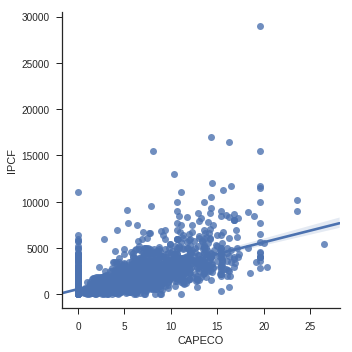

In [54]:
sns.lmplot(x = 'CAPECO', y ='IPCF',data=ingresos)
plt.ylabel('IPCF')
plt.xlabel('CAPECO')

In [55]:
y = ingresos['IPCF'].copy().values
X = sm.add_constant(ingresos['CAPECO'].copy().values)
w = ingresos.PONDERA.copy().values
    
#run model
lm = sm.WLS(y, X, weights=1. / w).fit()
print lm.summary()


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.368
Model:                            WLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     1571.
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          3.47e-271
Time:                        19:07:49   Log-Likelihood:                -23422.
No. Observations:                2703   AIC:                         4.685e+04
Df Residuals:                    2701   BIC:                         4.686e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        640.9262     40.701     15.747      0.0

# sin outliers

In [56]:
mask = (ingresos.IPCF  < 12000) & (ingresos.CAPECO> 0)

In [63]:
ingresosNoOut=ingresos.copy()[mask]

In [64]:
y = ingresosNoOut['IPCF'].values
X = sm.add_constant(ingresosNoOut['CAPECO'].values)
w = ingresosNoOut.PONDERA.values
    
#run model
lm = sm.WLS(y, X, weights=1. / w).fit()
print lm.summary()


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            WLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     2258.
Date:                Thu, 13 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:12:05   Log-Likelihood:                -18734.
No. Observations:                2205   AIC:                         3.747e+04
Df Residuals:                    2203   BIC:                         3.748e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         68.3721     46.201      1.480      0.1

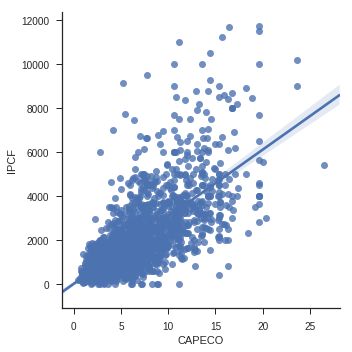

In [65]:
sns.lmplot(x = 'CAPECO', y ='IPCF',data=ingresosNoOut)
plt.ylabel('IPCF')
plt.xlabel('CAPECO')

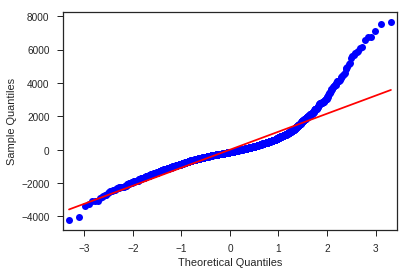

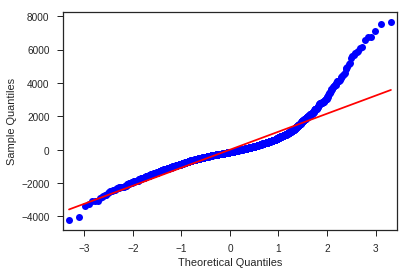

In [66]:
qqplot(lm.resid,line='r')

In [70]:
ingresosNoOut['predict'] = lm.predict()
ingresosNoOut['resid'] = lm.resid
ingresosNoOut['residStd'] = (ingresosNoOut.resid - ingresosNoOut.resid.mean())/ingresosNoOut.resid.std()
ingresosNoOut.head()

,id,IPCF,PONDERA,CAPECO,predict,resid,residStd
1,3078611,1450.0,1674,5.351187,1651.206335,-201.206335,-0.172916
3,3082781,5000.0,1320,17.087992,5122.850463,-122.850463,-0.105391
4,3119371,2750.0,1281,10.688689,3229.992583,-479.992583,-0.413166
5,3113561,1750.0,1348,4.086409,1277.096175,472.903825,0.408012
6,1563001,2962.5,1174,10.889023,3289.249570,-326.749570,-0.281106


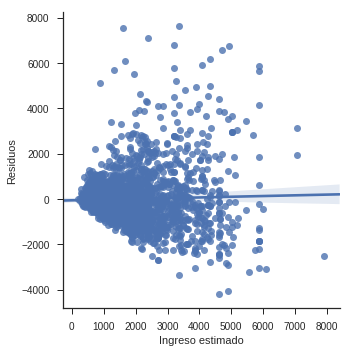

In [73]:
sns.lmplot(x = 'predict', y ='resid',data=ingresosNoOut)
plt.ylabel('Residuos')
plt.xlabel('Ingreso estimado')

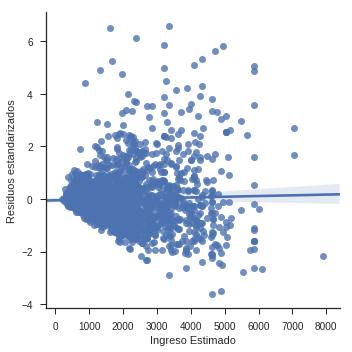

In [74]:
sns.lmplot(x = 'predict', y ='residStd',data=ingresosNoOut)
plt.ylabel('Residuos estandarizados')
plt.xlabel('Ingreso Estimado')

Se observa que la variabilidad en los residuos es mayor en los tramos de ingreso superiores. No es constante. HAY UNA SUBESTIMACION CUANDO SE USA EL CAPECO PARA PREDECIR INGRESO

## Residuos con p21 y el exponente de lo predicho

In [22]:
ind3t10Model['predictedE'] = np.exp(model.predict(X))

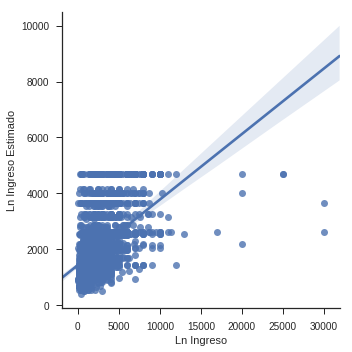

In [23]:
sns.lmplot(x = 'P21', y ='predictedE',data=ind3t10Model)
plt.xlabel('Ln Ingreso')
plt.ylabel('Ln Ingreso Estimado')

In [24]:
ind3t10Model['residE'] = ind3t10Model.P21 - ind3t10Model.predictedE 
print 'media ponderada de los residuos:%.4f'%np.average(ind3t10Model.residE, weights=1./ind3t10Model.PONDERA)

media ponderada de los residuos:472.2894


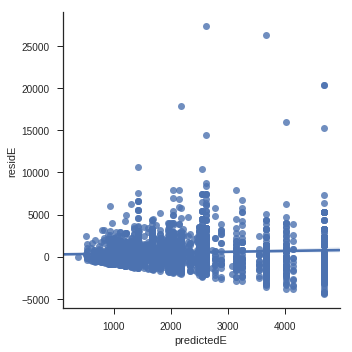

In [25]:
sns.lmplot(x = 'predictedE', y ='residE',data=ind3t10Model)


In [26]:
ind3t10Model['residEStd'] = (ind3t10Model.residE - ind3t10Model.residE.mean()) / ind3t10Model.resid.std()

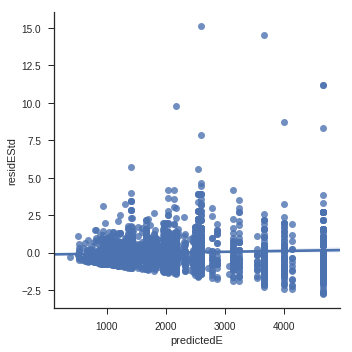

In [28]:
sns.lmplot(x = 'predictedE', y ='residEStd',data=ind3t10Model)
